In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy.optimize import curve_fit
import sys
from scipy import stats

In [2]:
sys.path.append('../MyExternal_Functions')
from MyExternalFunctions import Chi2Regression, UnbinnedLH, BinnedLH

### Misc Measurements

In [3]:
#Height of the mass:
Lod_h = 36.45*1e-3 #mm
Lod_h_sigma = 0.05*1e-3


### Individual length measurements:

In [4]:
data_L_human = np.array([ 182.1,  182.06 , 182.11,   181.75])*1e-2
guessed_sigma_L = np.array([0.1,  0.05 , 0.01, 0.05  ])*1e-2

data_L_human_after = np.array([182.15,181.9, 182.08, 181.2])*1e-2
guessed_sigma_L_after = np.array([0.05,0.1,0.05,0.1])*1e-2

L = np.sum(data_L_human/guessed_sigma_L**2)/np.sum(1/guessed_sigma_L**2)
sigma_L = np.sqrt(1/(np.sum(1/guessed_sigma_L**2)))

L_late = np.sum(data_L_human_after/guessed_sigma_L_after**2)/np.sum(1/guessed_sigma_L_after**2)
sigma_L_late = np.sqrt(1/(np.sum(1/guessed_sigma_L_after**2)))

print(f"String length: {L} +/- {sigma_L}")
print(f"String length: {L_late} +/- {sigma_L_late}")

L = L + Lod_h/2
sigma_L = np.sqrt(Lod_h_sigma**2/4 + sigma_L**2)

String length: 1.820948623853211 +/- 9.578262852211514e-05
String length: 1.8200200000000004 +/- 0.00031622776601683794


### For continuous period measurements:

<ValueView mu=-6.841204214178691e-11 sigma=0.04862993916868928>
Estimated RMS on period: 0.04862993916868928


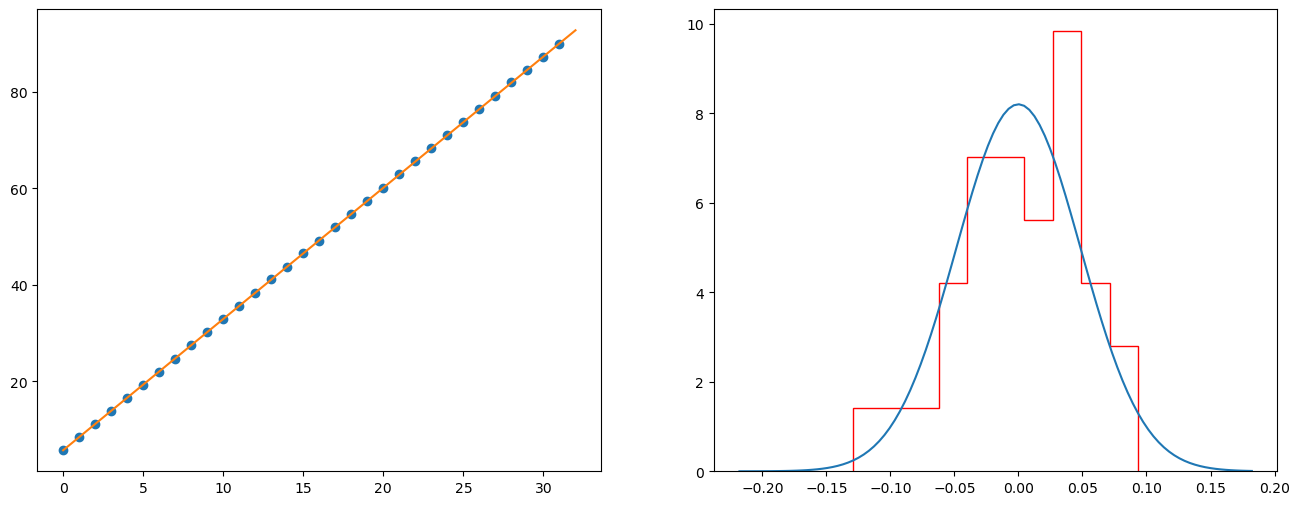

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax = ax.flatten()

#Import data:
data_Period_cumulated = np.genfromtxt('robin1.dat')
data_Period_cumulated = data_Period_cumulated[:,1]

N = np.arange(len(data_Period_cumulated))
# Fit accumulated time as function of N, to obtain uncertainties:
def linear_fit(x, a, b):
    return a*x+b

par, cov = curve_fit(linear_fit, N, data_Period_cumulated)

X = np.linspace(0,len(N),100)
Y = linear_fit(X, *par)
ax[0].plot(N,data_Period_cumulated, 'o')
ax[0].plot(X,Y)

# Calculate residuals and plot in histogram:
residuals = data_Period_cumulated - linear_fit(N, *par)
counts, bins = np.histogram(residuals, density = True)
bin_centers = (bins[1:] + bins[:-1])/2

ax[1].stairs(counts, bins, color='red')

#Fitting histogram to obtain RMS on period measurements:
def gauss_pdf(x, mu, sigma) :
    """Gaussian"""
    return 1 / np.sqrt(2*np.pi) / sigma * np.exp( -0.5 * (x-mu)**2 / sigma**2)

#Unbinned Likelihood Version:
ullh_obj = UnbinnedLH(gauss_pdf, residuals, bound=(-0.2, 0.2))
minuit_fit = Minuit(ullh_obj, mu=0, sigma=0.05)
minuit_fit.errordef = Minuit.LIKELIHOOD     # Value for likelihood fits
minuit_fit.migrad()           # Perform the actual fit


mu, sigma = minuit_fit.values
X = np.linspace(min(bin_centers)-0.1, max(bin_centers)+0.1, 100)
# ax[1].plot(residuals, gauss_pdf(residuals, 5, mu, sigma),'o')
ax[1].plot(X, gauss_pdf(X, mu, sigma))
print(minuit_fit.values)
print(f"Estimated RMS on period: {sigma}")

### Re-fitting period, now including estimated RMS:

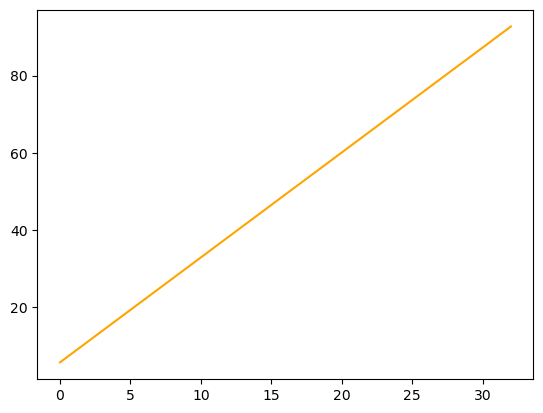

Fit:   Chi2: 32.000     P-value: 0.41673361515092694


Final measurement of period T: 2.720 +/- 0.001


In [21]:
chi2fit_linear = Chi2Regression(linear_fit, N, data_Period_cumulated, np.ones(len(N))*sigma)

minuit_chi2fit_linear = Minuit(chi2fit_linear, a = 1, b = 10)
minuit_chi2fit_linear.errordef = 1.0
minuit_chi2fit_linear.migrad()

X = np.linspace(0,len(N),100)
Y = linear_fit(X, *minuit_chi2fit_linear.values)
plt.errorbar(N,data_Period_cumulated, np.ones(len(N))*sigma, fmt="none")
plt.plot(X,Y, color="orange")
plt.show()

T = minuit_chi2fit_linear.values['a']
sigma_T = minuit_chi2fit_linear.errors['a']

chi2 = minuit_chi2fit_linear.fval
p_value = stats.chi2.sf(chi2, len(N)-1)
print(f"Fit:   Chi2: {chi2:.3f}     P-value: {p_value}")
print("\n")
print("Final measurement of period T: {:.3f} +/- {:.3f}".format(T, sigma_T))

### Calculation and Error propagation for g

In [22]:
g = L * (2*np.pi/T)**2
sigma_g = np.sqrt( (2*np.pi/T)**2 * sigma_L**2 + (-2*L*(2*np.pi)**2/(T**3))**2 * sigma_T**2)

print(f"Result: {g:.3f} +/- {sigma_g:.3f}")

Result: 9.817 +/- 0.007
